# Introduction
This notebook contains the work for [Homework 4](https://github.com/lucamaiano/ADM/tree/master/2022/Homework_4) 
of [Algorithmic Methods for Data Mining 2022](http://aris.me/index.php/data-mining-ds-2022).

## Group Members
* Barba Paolo
* Girolami Mattia 
* Pelliccioni Gabriele


### 1 Finding Similar Custumer

In [4]:
import pandas as pd

import numpy as np

import seaborn as sns

from sklearn.cluster import KMeans

import scipy.stats

from sklearn.cluster import AgglomerativeClustering

from mpl_toolkits import mplot3d

from scipy.spatial.distance import cdist

import math

from functools  import reduce

from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import OneHotEncoder

import random 

import statistics

import datetime

from tqdm import tqdm

import time

import itertools

from sklearn import preprocessing

from pyensae.graphhelper import Corrplot

import matplotlib.pyplot as plt 

from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer



##  1.1 Set up the data

In [2]:
bt = pd.read_csv("bank_transactions.csv")      # Import the dataset
bt.dropna(inplace=True)                        # Dropping missing values 

In [3]:
# convert to timedate
bt.CustomerDOB = pd.to_datetime(bt.CustomerDOB)
bt.TransactionDate = pd.to_datetime(bt.TransactionDate)

In [151]:
def zeros(x):
    l = len(x)
    if l != 6:
        x = '0' * (6-l) + x
    return x

In [5]:
bt.TransactionTime = list(map(str,bt.TransactionTime))
bt.TransactionTime = list(map(zeros,bt.TransactionTime))
bt.TransactionTime = bt.TransactionTime.apply(lambda x: f'{x[:2]}:{x[2:4]}:{x[4:]}')
bt.TransactionTime = pd.to_datetime(bt.TransactionTime, format='%H:%M:%S')

In [6]:
bt.loc[bt.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = bt.loc[bt.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
bt.drop(bt[bt.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

In [7]:
#calculating customer age
bt['CustomerAge'] = (( pd.to_datetime('today') - bt.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
bt['CustomerAge'] = bt['CustomerAge'].astype(int)

In [8]:
bt['TransactionAmount (INR)'] = bt['TransactionAmount (INR)'].astype(int)
bt['Utilisation'] = bt['CustAccountBalance'] - bt['TransactionAmount (INR)']

In [9]:
bt["NewID"] = bt["CustomerID"] + "-" + bt["CustomerDOB"].astype(str)

In [14]:
bt["CustLocation"] = bt.CustLocation.apply(lambda x: x.replace(" ","_"))

In [10]:
#to load
bt = pd.read_pickle("bank.pkl")

## 1.2) Fingerprint hashing

For this task we used only the columns we think are appropriate.

In [170]:
data = bt[["NewID" , "CustAccountBalance" , "CustGender" , "CustLocation" , "TransactionAmount (INR)" , "CustomerAge" ]]

Now we create a new variable : NewID , concatenating the Custumer ID and the date of born , in order to group the data for unique custumer.

In [172]:
group_data = data.groupby("NewID").last()        #Take only the last record for each Custumer

To perform Locality Sensitive Hashing we transform the variables into classes setting threshold based on quantile of the distribution. 

In [ ]:
##### CLASS AGE : 
# Young : the first 25% of the youngest custumer
# Adult : from 25% to 75% of the custumer age
# elderly: after the 75% of the custumer age

q1_age = group_data.CustomerAge.quantile(.25)    # 25th qunantile for the Custumer Age

q3_age = group_data.CustomerAge.quantile(.75)    # 75th qunantile for the Custumer Age

group_data.CustomerAge[group_data.CustomerAge <= q1_age ] =  1
group_data.CustomerAge[ (group_data.CustomerAge > q1_age ) & ( group_data.CustomerAge <= q3_age )] = 2
group_data.CustomerAge[group_data.CustomerAge > q3_age ] = 3

group_data.CustomerAge[group_data.CustomerAge ==  1 ] = "young"
group_data.CustomerAge[group_data.CustomerAge ==  2 ] = "adult"
group_data.CustomerAge[ group_data.CustomerAge == 3 ] = "elderly"


In [ ]:
##### CLASS on Custumer Balance : 
# Balance_1 : the first 20% of the custumer who owned less 
# Balance_2 : from 20% to 40% 
# Balance_3 : from 40% to 60% 
# Balance_4 : from 60% to 80% 
# Balance_5 : from 80% to 100% 

q1_bal = group_data.CustAccountBalance.quantile(.2)
q2_bal = group_data.CustAccountBalance.quantile(.4)
q3_bal = group_data.CustAccountBalance.quantile(.6)
q4_bal = group_data.CustAccountBalance.quantile(.8)


group_data.CustAccountBalance[  group_data.CustAccountBalance <= q1_bal ] =  1
group_data.CustAccountBalance[ (group_data.CustAccountBalance > q1_bal ) & ( group_data.CustAccountBalance <= q2_bal )] = 2
group_data.CustAccountBalance[ (group_data.CustAccountBalance > q2_bal ) & ( group_data.CustAccountBalance <= q3_bal )] = 3
group_data.CustAccountBalance[ ( group_data.CustAccountBalance > q3_bal) &   ( group_data.CustAccountBalance <= q4_bal )] = 4
group_data.CustAccountBalance[  group_data.CustAccountBalance > q4_bal ] =  5


group_data.CustAccountBalance[ group_data.CustAccountBalance == 1 ] = "balance_1"
group_data.CustAccountBalance[ group_data.CustAccountBalance == 2 ] = "balance_2"
group_data.CustAccountBalance[group_data.CustAccountBalance  == 3 ] = "balance_3"
group_data.CustAccountBalance[group_data.CustAccountBalance  == 4 ] = "balance_4"
group_data.CustAccountBalance[ group_data.CustAccountBalance == 5 ] = "balance_5"


In [ ]:
##### CLASS on Transaction Amount: 
# Transaction_1 : the first 20% of the custumer who has less  transaction amount
# Transaction_2 : from 20% to 40% 
# Transaction_3 : from 40% to 60% 
# Transaction_4 : from 60% to 80% 
# Transaction_5 : from 80% to 100% 


q1_tra = group_data["TransactionAmount (INR)"].quantile(.2)
q2_tra = group_data["TransactionAmount (INR)"].quantile(.4)
q3_tra = group_data["TransactionAmount (INR)"].quantile(.6)
q4_tra = group_data["TransactionAmount (INR)"].quantile(.8)

group_data["TransactionAmount (INR)"][group_data["TransactionAmount (INR)"] <= q1_tra ] = 1
group_data["TransactionAmount (INR)"][ (group_data["TransactionAmount (INR)"] > q1_tra ) & (group_data["TransactionAmount (INR)"] <= q2_tra ) ] = 2
group_data["TransactionAmount (INR)"][ (group_data["TransactionAmount (INR)"] > q2_tra ) & (group_data["TransactionAmount (INR)"] <= q3_tra ) ] = 3
group_data["TransactionAmount (INR)"][ (group_data["TransactionAmount (INR)"] > q3_tra)  & (group_data["TransactionAmount (INR)"] <= q4_tra ) ] = 4
group_data["TransactionAmount (INR)"][group_data["TransactionAmount (INR)"] > q4_tra ] = 5




group_data["TransactionAmount (INR)"][group_data["TransactionAmount (INR)"] == 1 ] = "Transaction_1"
group_data["TransactionAmount (INR)"][group_data["TransactionAmount (INR)"] == 2 ] = "Transaction_2"
group_data["TransactionAmount (INR)"][group_data["TransactionAmount (INR)"] == 3 ] = "Transaction_3"
group_data["TransactionAmount (INR)"][group_data["TransactionAmount (INR)"] == 4 ] = "Transaction_4"
group_data["TransactionAmount (INR)"][group_data["TransactionAmount (INR)"] == 5 ] = "Transaction_5"

In [176]:
##### CLASS on Custumer Location: 
# We set all the city that are not in the most important city in India as a Village:
# The most important city we considered are :  NEW_DELHI , MUMBAI , BANGALORE , DELHI , HYDERABAD , AHMEDABAD , CHENNAI , KOLKATA and PUNE.
group_data.CustLocation[ (group_data.CustLocation != "NEW_DELHI") & (group_data.CustLocation != "MUMBAI") & (group_data.CustLocation !=  "BANGALORE") &
            (group_data.CustLocation != "DELHI") & (group_data.CustLocation != "HYDERABAD")  & (group_data.CustLocation != "AHMEDABAD") &
            (group_data.CustLocation != "CHENNAI") & (group_data.CustLocation != "KOLKATA")  & (group_data.CustLocation != "PUNE")] = "Village"

Now we transform all the observations into a string in order to use One Hot Encoder for each observation.

In [187]:
# CODE to transfrom into a single string
x = group_data.to_string(header=False,
    index=False,
    index_names=False).split('\n')

# CODE to transfrom the string into a set of strings
vals = [(ele.split()) for ele in x]

In [188]:
# Perform One Hot Encoder
one_hot = OneHotEncoder(handle_unknown= "ignore", sparse= False, dtype= bool )   

Vect = one_hot.fit(vals)        # Fit the Encoder with our values

Matr = one_hot.transform(vals)  # Transform values into one hot

tMatr = Matr.transpose()        # Trasponse of the Matrix


In [189]:
number_of_items     = int(tMatr.shape[0])
number_of_custumer  = int(tMatr.shape[1])

Build the Signature Matrix:
* 1) Shuffled the row of the Matrix 
* 2) Take the index of the first True Value for each column
* 3) Repeat the step as many time we want


In [192]:
number_of_permutation = 15
signature_matrix = np.zeros(( number_of_permutation , number_of_custumer) , dtype= int)   # Pre allocate the matrix with the right shape
random.seed(123)                                       # Set the seed 
for i in range( number_of_permutation):                # Looping 
    np.random.shuffle(tMatr)                           # Shuffle the Matrix
    for custumer in tqdm(range(tMatr.shape[1]), colour= "cyan"):                              # Looping over the custumer
        signature_matrix[i ,custumer] = np.where(tMatr[ :, custumer] == True )[0][0]  + 1     # Find the first custumer

100%|██████████| 984103/984103 [00:02<00:00, 456601.83it/s]


In [193]:
signature_matrix

array([[ 3,  1,  2, ...,  1,  4,  1],
       [ 4,  3,  6, ..., 10,  3,  4],
       [12,  1,  4, ...,  2,  1,  2],
       ...,
       [ 3,  2,  6, ...,  4,  6,  3],
       [ 4,  6,  1, ..., 19,  6, 11],
       [ 1, 11,  2, ..., 14,  4,  8]])

We devide the signature matrix above into bands of 5 rows each, and each band is hashed separately. We consider as a similarity any custumer with the same first 5 row.


In [245]:
similar_custumer = {}    # Set the empty dictionary 
len_band = 3             # Length of the bands
bands =  number_of_permutation // len_band    # Set the band
for i in range(bands):   # Loop over the bands
    band =  signature_matrix[ i*len_band : (i+1)*len_band ,:]
    for j in tqdm(range(len(band[0])) , colour= "GREEN"):  # Loop over the single band
        if str(band[:,j]) not in similar_custumer.keys():     # Create the bucket if absent
            similar_custumer[str(band[:,j])] = [j + 1]
        else: 
            similar_custumer[str(band[:,j])].append(j+1)      # Populate the bucket

100%|██████████| 984103/984103 [00:44<00:00, 22004.90it/s]


## 1.3) Locality Sensitive Hashing

In [202]:
query = pd.read_csv("query_users.csv" , sep = ",")    # Load the dataset

Set up the query dataset as the same structure of the first one

In [203]:
# Convert to timedate
query.CustomerDOB = pd.to_datetime(query.CustomerDOB)
query.TransactionDate = pd.to_datetime(query.TransactionDate)

# Set Data time
query.TransactionTime = list(map(str,query.TransactionTime))
query.TransactionTime = list(map(zeros,query.TransactionTime))
query.TransactionTime = query.TransactionTime.apply(lambda x: f'{x[:2]}:{x[2:4]}:{x[4:]}')
query.TransactionTime = pd.to_datetime(query.TransactionTime, format='%H:%M:%S')

query.loc[query.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = query.loc[query.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
query.drop(query[query.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

# Calculating customer age
query['CustomerAge'] = (( pd.to_datetime('today') - query.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
query['CustomerAge'] = query['CustomerAge'].astype(int)

# Set the TransactionAmount
query['TransactionAmount (INR)'] = query['TransactionAmount (INR)'].astype(int)
query['Utilisation'] = query['CustAccountBalance'] - query['TransactionAmount (INR)']

# Set the CustLocation
query["CustLocation"] = query.CustLocation.apply(lambda x: x.replace(" ","_"))

Transform the relevant features into classes

In [ ]:
data_query = query[["CustAccountBalance" , "CustGender" , "CustLocation" , "TransactionAmount (INR)" , "CustomerAge" ]]

##### CLASS AGE : 
# Young : the first 25% of the youngest custumer
# Adult : from 25% to 75% of the custumer age
# elderly: after the 75% of the custumer age



data_query.CustomerAge[data_query.CustomerAge <= q1_age ] =  1
data_query.CustomerAge[ (data_query.CustomerAge > q1_age ) & ( data_query.CustomerAge <= q3_age )] = 2
data_query.CustomerAge[data_query.CustomerAge > q3_age ] = 3

data_query.CustomerAge[data_query.CustomerAge ==  1 ] = "young"
data_query.CustomerAge[data_query.CustomerAge ==  2 ] = "adult"
data_query.CustomerAge[ data_query.CustomerAge == 3 ] = "elderly"


##### CLASS on Custumer Balance : 
# Balance_1 : the first 20% of the custumer who owned less 
# Balance_2 : from 20% to 40% 
# Balance_3 : from 40% to 60% 
# Balance_4 : from 60% to 80% 
# Balance_5 : from 80% to 100% 




data_query.CustAccountBalance[  data_query.CustAccountBalance <= q1_bal ] =  1
data_query.CustAccountBalance[ (data_query.CustAccountBalance > q1_bal ) &   ( data_query.CustAccountBalance <= q2_bal )] = 2
data_query.CustAccountBalance[ (data_query.CustAccountBalance > q2_bal ) &   ( data_query.CustAccountBalance <= q3_bal )] = 3
data_query.CustAccountBalance[ ( data_query.CustAccountBalance > q3_bal) &   ( data_query.CustAccountBalance <= q4_bal )] = 4
data_query.CustAccountBalance[  data_query.CustAccountBalance > q4_bal ] =  5


data_query.CustAccountBalance[ data_query.CustAccountBalance == 1 ] = "balance_1"
data_query.CustAccountBalance[ data_query.CustAccountBalance == 2 ] = "balance_2"
data_query.CustAccountBalance[ data_query.CustAccountBalance == 3 ] = "balance_3"
data_query.CustAccountBalance[ data_query.CustAccountBalance == 4 ] = "balance_4"
data_query.CustAccountBalance[ data_query.CustAccountBalance == 5 ] = "balance_5"



##### CLASS on Transaction Amount: 
# Transaction_1 : the first 20% of the custumer who has less  transaction amount
# Transaction_2 : from 20% to 40% 
# Transaction_3 : from 40% to 60% 
# Transaction_4 : from 60% to 80% 
# Transaction_5 : from 80% to 100% 


data_query["TransactionAmount (INR)"][data_query["TransactionAmount (INR)"] <= q1_tra ] = 1
data_query["TransactionAmount (INR)"][ (data_query["TransactionAmount (INR)"] > q1_tra ) & (data_query["TransactionAmount (INR)"] <= q2_tra ) ] = 2
data_query["TransactionAmount (INR)"][ (data_query["TransactionAmount (INR)"] > q2_tra ) & (data_query["TransactionAmount (INR)"] <= q3_tra ) ] = 3
data_query["TransactionAmount (INR)"][ (data_query["TransactionAmount (INR)"] > q3_tra)  & (data_query["TransactionAmount (INR)"] <= q4_tra ) ] = 4
data_query["TransactionAmount (INR)"][data_query["TransactionAmount (INR)"] > q4_tra ] = 5




data_query["TransactionAmount (INR)"][data_query["TransactionAmount (INR)"] == 1 ] = "Transaction_1"
data_query["TransactionAmount (INR)"][data_query["TransactionAmount (INR)"] == 2 ] = "Transaction_2"
data_query["TransactionAmount (INR)"][data_query["TransactionAmount (INR)"] == 3 ] = "Transaction_3"
data_query["TransactionAmount (INR)"][data_query["TransactionAmount (INR)"] == 4 ] = "Transaction_4"
data_query["TransactionAmount (INR)"][data_query["TransactionAmount (INR)"] == 5 ] = "Transaction_5"


##### CLASS on Custumer Location: 
# We set all the city that are not in the most important city in India as a Village:
# The most important city we considered are :  NEW_DELHI , MUMBAI , BANGALORE , DELHI , HYDERABAD , AHMEDABAD , CHENNAI , KOLKATA and PUNE.
data_query.CustLocation[ (data_query.CustLocation != "NEW_DELHI") & (data_query.CustLocation != "MUMBAI") & (data_query.CustLocation !=  "BANGALORE") &
            (data_query.CustLocation != "DELHI") & (data_query.CustLocation != "HYDERABAD")  & (data_query.CustLocation != "AHMEDABAD")  &
            (data_query.CustLocation != "CHENNAI") & (data_query.CustLocation != "KOLKATA")  & (data_query.CustLocation != "PUNE")] = "Village"

Repeat the same procedure as in 1.2)

In [217]:
# CODE to transfrom into a single string
x_query = data_query.to_string(header=False,
    index=False,
    index_names=False).split('\n')

# CODE to transfrom the string into a set of strings
vals_query = [(ele.split()) for ele in x_query]

In [218]:
# Perform One Hot Encoder
one_hot_query = OneHotEncoder(handle_unknown= "ignore", sparse= False, dtype= bool )   

Vect_query = one_hot_query.fit(vals_query)        # Fit the Encoder with our values

Matr_query = one_hot_query.transform(vals_query)      # Transform values into one hot

tMatr_query = Matr_query.transpose()       # Trasponse of the Matrix

In [220]:
number_of_items_query     = int(tMatr_query.shape[0])
number_of_custumer_query  = int(tMatr_query.shape[1])

In [221]:
number_of_permutation = 15
signature_matrix_query = np.zeros(( number_of_permutation , number_of_custumer_query) , dtype= int)   # Pre allocate the matrix with the right shape
random.seed(123)                                       # Set the seed 
for i in range( number_of_permutation):                # Looping 
    np.random.shuffle(tMatr_query)                     # Shuffle the Matrix
    for custumer in tqdm(range(tMatr_query.shape[1]), colour= "#4682B4"):                              # Looping over the custumer
        signature_matrix_query[i ,custumer] = np.where(tMatr_query[ :, custumer] == True )[0][0]  + 1  # Find the first custumer

100%|██████████| 46/46 [00:00<00:00, 211787.03it/s]


In [247]:
similar_custumer_query = {}    # Set the empty dictionary 
len_band = 3             # Length of the bands
bands =  number_of_permutation // len_band    # Set the band
for i in range(bands):   # Loop over the bands
    band =  signature_matrix_query[ i*len_band : (i+1)*len_band ,:]
    for j in tqdm(range(len(band[0])) , colour= "#FE019A"):         # Loop over the single band
        if str(band[:,j]) not in similar_custumer_query.keys():     # Create the bucket if absent
            similar_custumer_query[str(band[:,j])] = [j + 1]
        else: 
            similar_custumer_query[str(band[:,j])].append(j+1)      # Populate the bucket

100%|██████████| 46/46 [00:00<00:00, 17982.85it/s]


### Compute the scores:
The similarity score we are going to use is: 
$$ Scores_{custumer\hspace{.1cm}i} = \frac{\#custumer \hspace{.1cm} similar \hspace{.1cm}to \hspace{.1cm}i-th \hspace{.1cm}custumer }{total\hspace{.1cm} number\hspace{.1cm}of \hspace{.1cm}custumer \hspace{.1cm}in\hspace{.1cm} the \hspace{.1cm}dataset}$$

where we claim that a custumer is similar to an other one if the belong to the same bucket.

In [361]:
points = {}      # pre set the dictionary
for key in tqdm(similar_custumer_query.keys() , colour = "yellow"):  # Loop over the query buckets
    for query_custumer in similar_custumer_query[str(key)]:          # Loop over the custumer of each query bucket
        if key in similar_custumer.keys():                           # Bucket needs to be also in the previous bucket
            if str(query_custumer) not in points.keys() :            # Create the k if absent
                points[str(query_custumer)] = list(similar_custumer[str(key)])
            else:                                                    # Populate the dictionary
                points[str(query_custumer)] = points[str(query_custumer)] + similar_custumer[str(key)]


100%|██████████| 141/141 [00:00<00:00, 2020.61it/s]


In [ ]:
# DEFINE a function unique value in a list
def nunique(list):
    list_set = set()
    for x in list:
        if type(x) == int:
            list_set.add(x)
    return len(list_set)

In [431]:
scores = {}  # Score for each custumer in the query dataset
for k in tqdm(points.keys() , colour= "#d4af37"):
    scores[f"Custumer: {k}"] = round( nunique(points[k]) / number_of_custumer, 3 )   # Compute the score

100%|██████████| 44/44 [00:00<00:00, 129.35it/s]


In [428]:
best_scores = sorted(scores.items(), key = lambda x : x[1] , reverse = True)[:10]    # Take the 10 custumer with the best score 

In [429]:
best_scores

[('Custumer: 13', 0.197),
 ('Custumer: 30', 0.156),
 ('Custumer: 22', 0.151),
 ('Custumer: 46', 0.146),
 ('Custumer: 23', 0.124),
 ('Custumer: 37', 0.101),
 ('Custumer: 34', 0.1),
 ('Custumer: 7', 0.092),
 ('Custumer: 35', 0.066),
 ('Custumer: 4', 0.053)]

### Further Analysis

In our LSH algorithm we set the parameter as the following:

* b = 5 number of bands
* r = 3 number of rows

According to the following probability 
$$ P =  1 - ( 1  - s^{r})^{b}$$

Which is the probability that we will label two rows as a candidate pair, given they have a true similarity score.
According to the formula of the trantiont point :
$$ t \approx (\frac{1}{b})^{\frac{1}{r}} = 0.5848 $$


We select candidates with similarity score ≥  :


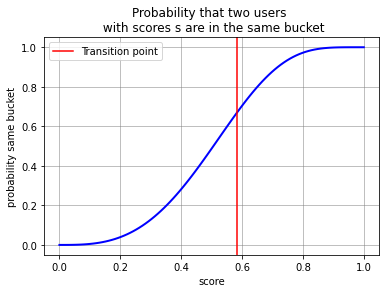

In [467]:
import matplotlib.pyplot as plt

x = np.linspace(0,1,100)


# the function, which is y = x^2 here
y =  1 - ( 1  - x**3)**5

# setting the axes at the centre
fig = plt.figure()
# plot the function
plt.plot(x,y, 'b', linewidth=2, markersize=12 )
plt.axvline(0.5848 , color='r' , label = "Transition point")
plt.xlabel('score') 
plt.ylabel('probability same bucket') 
plt.legend()
plt.grid(color='gray', linestyle='-', linewidth = .5)
plt.title("Probability that two users \n with scores s are in the same bucket")

# show the plot
plt.show()

### 2. Grouping customers together!

### 2.1 Getting your data + feature engineering

In [ ]:
#Define an empty dataframe
Features = pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)

#Number of transaction
Features["Num_of_Transaction"] = bt[["CustomerID","TransactionID"]].groupby("CustomerID").count()

#Transaction with balance > 100:
Features["Balance>100_USD"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").apply(lambda x: (x>100).sum())


#Average Amount of the transactions:
Features["Average_Amount"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").agg(Average_Amount=("TransactionAmount (INR)",np.mean))


#Average Balance:
Features["Average_Balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.mean))


#Utilisation = Average difference between the balance and the transaction amount:
pd.options.mode.chained_assignment = None      #Avoid the red banner
bt["Utilisation"] = bt["CustAccountBalance"]-bt["TransactionAmount (INR)"]  #create "Utilisation" column
Features["Utilisation"] = bt[["CustomerID","Utilisation"]].groupby("CustomerID").agg(Utilisation=("Utilisation",np.mean))  #calculate the mean  

#Mode od Gender of the customer:  
Features["gender"]=bt[["CustomerID","CustGender"]].groupby("CustomerID").agg(CustGender =("CustGender",statistics.mode))

#Most frequent location of the customer
Features["Most_Frequent_Location"] = bt[["CustomerID","CustLocation"]].groupby("CustomerID").agg(CustLocation =("CustLocation",statistics.mode))


### Adding 20 additional features

* 1 Customer age : Median of the age per customer
* 2 Max_transaction : Maximum transaction of the customer
* 3 Min_transaction : Minimun transaction of the customer
* 4 Important_custumer : Define as Average_Balance greater than 80% of the average balance of all customers
* 5 Number_of_teenager: number of the teen ager (Define as 20 years before the last transaction registered )
* 6 Class Age :  ( young <= 25 ; 26 < grown-up <= 60  ; elderly > 60 )
* 7 "Balance<80_USD : Number of Transaction with balance < 80:
* 8 Date_of_birth : Date of birth of the first costumer
* 9  Maximum Balance : the maximum balance value that a custumer has
* 10 Minimum Balance : the minimum balance value that a custumer has
* 11 Median_transaction : Median transaction  of the custumer
* 12 Number of woman 
* 13 Number of man
* 14 Place_last : Place of last transaction
* 15 PLace_first : Place of the first transaction
* 16 Number_transaction>median : number of transaction greter than the median of transactions
* 17 Date_last: Date of the last transaction
* 18 Transaction_st_dev : Standard deviation of the transactions of the cosumer
* 19 Number_transaction>q3 : Number of transaction grater than third quartile
* 20 Transaction_CV : Coefficient of varation of the transaction of the custumer

In [ ]:
# 1)
Features["Costumer_age"] = bt[["CustomerID","CustomerAge"]].groupby("CustomerID").median()

# 2)
Features["Max_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").max()

# 3)
Features["Min_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").min()

# 4)
Features["Important_custumer"] = Features["Average_Balance"] > Features["Average_Balance"].quantile(.8)

# 5)
# First  set the date after that people born are teen ager 
d1 = datetime.datetime(max(bt.TransactionDate).year - 20 ,max(bt.TransactionDate).month , max(bt.TransactionDate).day)
bt['teen'] = bt.CustomerDOB > d1
# Create the variables
Features["Number_of_teenager"] = bt[["CustomerID","teen"]].groupby("CustomerID").agg(teen =("teen", sum )) 

# 6)
# Here  we  copy the variable age
Features["Class_Age"]  = Features["Costumer_age"]

# Set a single age age
Features.Class_Age[ Features["Class_Age"] <= 25]  = 0

Features.Class_Age[ (Features["Class_Age"] > 25) &  (Features["Class_Age"] <= 60) ]   = 1

Features.Class_Age[ Features["Class_Age"] > 60 ]  = 2


# 7)
Features["Balance<80_USD"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID")["CustAccountBalance"].apply(lambda x: (x<80).sum())

# 8)
Features["Date_of_birth"] = bt[["CustomerID","CustomerDOB"]].groupby("CustomerID").first()

# 9)
Features["Maximum_balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.max))

# 10)
Features["Minimum_balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.min))

# 11)
Features["Median_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").median()

# 12)
Features["Number_of_woman"] = bt[["CustomerID","CustGender", "TransactionAmount (INR)" ]].groupby("CustomerID")["CustGender"].apply(lambda x: (x == "F").sum())

# 13)
Features["Number_of_man"] = bt[["CustomerID","CustGender", "TransactionAmount (INR)" ]].groupby("CustomerID")["CustGender"].apply(lambda x: (x == "M").sum())

# 14) 

Features["Place_last"] = bt[["TransactionDate","CustomerID","CustLocation"]].sort_values(by="TransactionDate").groupby("CustomerID")["CustLocation"].last()

# 15)
Features["Place_first"] = bt[["TransactionDate","CustomerID","CustLocation"]].sort_values(by="TransactionDate").groupby("CustomerID")["CustLocation"].first()

# 16)
m = bt["TransactionAmount (INR)"].median()
Features["Number_transaction>median"] = bt[["TransactionAmount (INR)" ,"CustomerID" ]].groupby("CustomerID").apply( lambda x : (x>m).sum()  )

# 17)
Features["Date_last"] = bt[["TransactionDate","CustomerID"]].sort_values(by="TransactionDate").groupby("CustomerID").last()

# 18)
deviance = bt[["TransactionAmount (INR)" ,"CustomerID" ]].groupby("CustomerID").std()
deviance.fillna(value=0 , inplace = True )
Features["Transaction_st_dev"] = deviance

# 19)
q = bt["TransactionAmount (INR)"].quantile(.75)
Features["Number_transaction>q3"] = bt[["TransactionAmount (INR)" ,"CustomerID" ]].groupby("CustomerID").apply( lambda x : (x>q).sum()  )

# 20)
Features["Transaction_CV"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").agg(CustGender =("TransactionAmount (INR)", scipy.stats.variation ))


In [ ]:
#save
Features.to_pickle("Custumer.pkl")

In [ ]:
#load
Custumer = pd.read_pickle("Custumer.pkl")

## 2.2 Choose your features (variables)!


Principal component analysis (PCA) allows us to summarize and to visualize the information in a data set containing individuals/observations described by multiple inter-correlated quantitative variables. Each variable could be considered as a different dimension. If we have more than 3 variables in your data sets, it could be very difficult to visualize a multidimensional hyperspace.


Principal component analysis is used to extract the important information from a multivariate  data table and to express this information as a set of few new variables called principal components. These new variables correspond to a linear combination of the originals. The number of principal components is less than or equal to the number of original variables.


The information in a given data set corresponds to the total variation it contains. The goal of PCA is to identify directions (or principal components) along which the variation in the data is maximal.

 In other words, PCA reduces the dimensionality of a multivariate quantitative dataset to a fewer number of  principal components, that can be visualized graphically, with minimal loss of information.



In order to perform the PCA analysis we need to normalize the data because PCA associate Variance with information, colliding variables into Principal components that explain a percentage of the variance / information of our data.

In our case we have variables as Number of transaction supported around (1,..,6) and others as Utilisation that can assume really huge values in comparison.

Variance, being a not a normalized statistic , doesn't allow us to compare itself between others variable.

Then, in conclusion, we are going to normalize the data and compute the PCA.

In [ ]:
# SELECT ONLY THE QUANTITATIVE VARIABLES
columns = [ "Num_of_Transaction" , "Balance>100_USD"   , "Average_Amount" ,
            "Costumer_age"  , "Average_Balance" , "Utilisation" , "Maximum_balance" ,
            "Minimum_balance" , "Median_transaction" , "Number_of_woman" ,  "Number_of_man",
            "Number_of_teenager" , "Balance<80_USD"  , "Minimum_balance"  , 
            "Number_transaction>median" , "Number_transaction>q3"  ]

In [ ]:
data_red = Custumer[columns] 

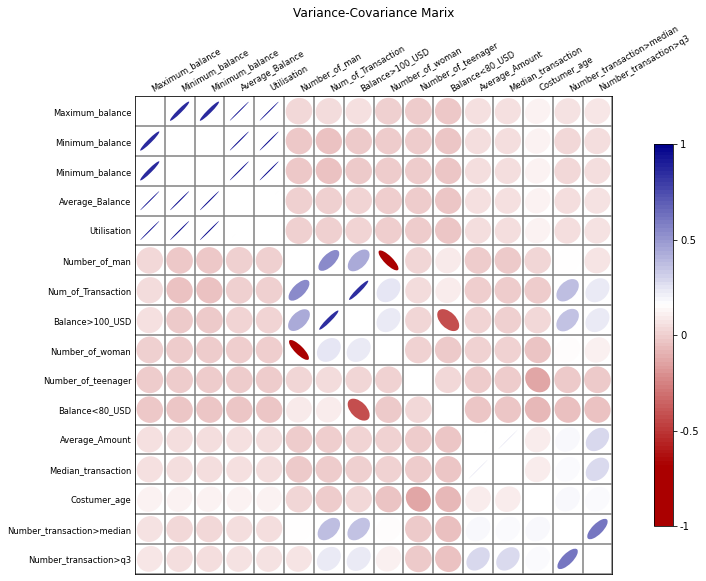

In [ ]:
c = Corrplot(data_red)
c.plot(figsize=(12,8))
plt.title("Variance-Covariance Marix")
plt.show()

In [ ]:
x = data_red.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()  
x_scaled = min_max_scaler.fit_transform(x)  # Normalize the variables
data_red = pd.DataFrame(x_scaled)         

In [ ]:
pca = PCA(n_components=13)            # Make 13 PCAs
pca_features = pca.fit_transform(data_red)  

print('Shape before PCA: ', data_red.shape)  
print('Shape after PCA: ', pca_features.shape)

Shape before PCA:  (839081, 16)
Shape after PCA:  (839081, 13)


After perform PCA , we compute the percentage ratio of explained cumulative variance.

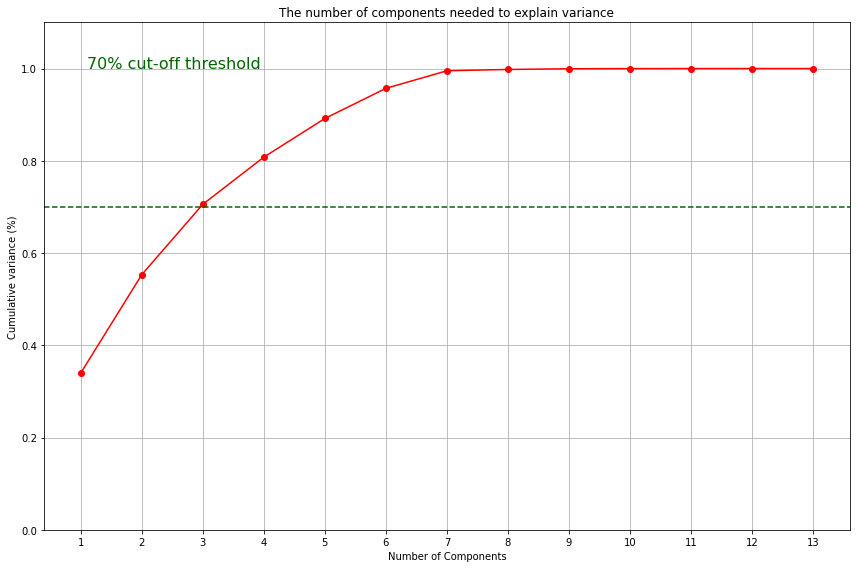

In [ ]:
plt.rcParams["figure.figsize"] = (12,8)

fig, ax = plt.subplots()
xi = np.arange(1, 14, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='red')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 14, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.7, color='darkgreen', linestyle='--')
plt.text(1.1, 1, '70% cut-off threshold', color = 'darkgreen', fontsize=16)

ax.grid()
plt.tight_layout()
plt.show()

## Comments:
Plots shown tha we need to use at least 3 Principal components in order to have at least the 70% of the variance

In [ ]:
pca = PCA(n_components =  3)
pca_features = pca.fit_transform(data_red)

After PCA we can use only 3 principal compenents and we can make a plot of them in three dimensions.
The following plots show the datapoints of the pca coloured matching with the number of transaction the custumer did.

/var/folders/5c/xp7pml6x75x32v16v990ccwc0000gn/T/ipykernel_1842/2869669177.py:15: MatplotlibDeprecationWarning:

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.



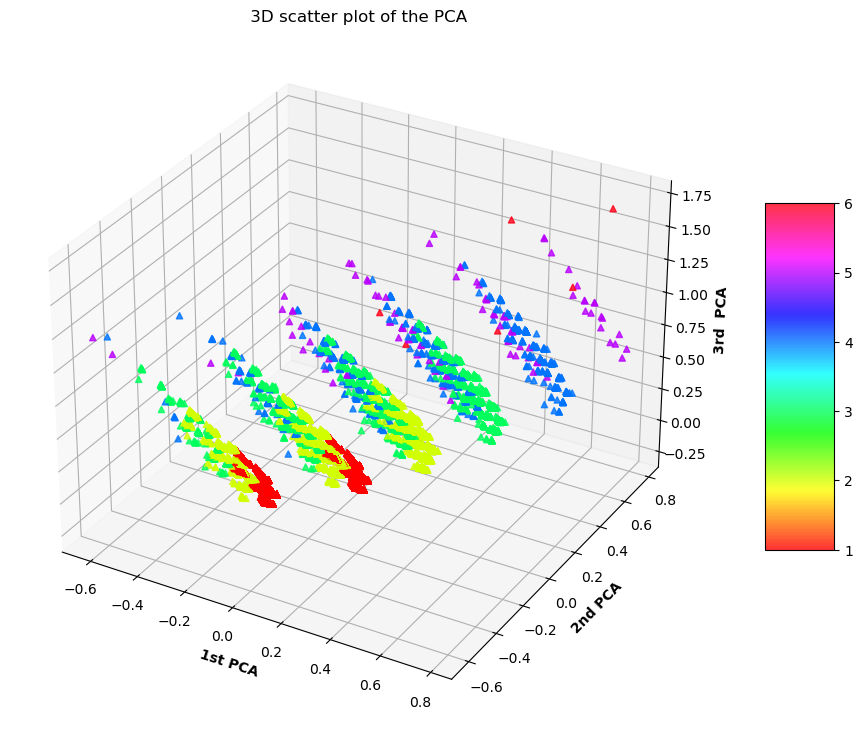

In [ ]:
# Creating dataset
z = pca_features[ : , :1 ]
x = pca_features[ : , 1:2 ]
y = pca_features[ : , 1:2 ]

# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

# Creating color map
my_cmap = plt.get_cmap('hsv')

# Creating plot
sctt = ax.scatter3D(x, y, z,
        alpha = 0.8,
        c =  Custumer.Num_of_Transaction ,
        cmap = my_cmap,
        marker ='^')

plt.title(" 3D scatter plot of the PCA")
ax.set_xlabel('1st PCA', fontweight ='bold')
ax.set_ylabel('2nd PCA', fontweight ='bold')
ax.set_zlabel('3rd  PCA', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.show()


# 2.3 Clustering!

In [ ]:
def k_means_by_scratch( data , k : int , max_iterations : int ):
    n = data.shape[0]                                              # Number of observation
    centroids = data[np.random.choice( n , k , replace= False)]    # Set the first centroids randomly
    closest = np.zeros(n).astype(int)                              # Pre set the the closest point
    number_of_iteration = 0                                        # Set the number of iterations
    while  number_of_iteration < max_iterations :                  # Condition Based on the maximum number iterations we want to do
        number_of_iteration += 1                                   # Updating the number of iteration
        old_closest = closest.copy()
        distances = []                                             # Copy the centroids       
        for point in data:                                         # Loop over the point
            distances.append(list(map( lambda x : math.dist( x , point )  , centroids   )))     # Compute the Euclidean distance

        closest = []                                               # Pre set the cloeset point
        for dis in distances:                                      # Loop over the distances
            a = reduce( lambda a , b : min(a , b) , dis)           # Find the minimun distance
            closest.append(dis.index(a))                           # Allocate the minimum distance
        closest = np.array(closest)                                # Find the  mimum distance for each point
        for i in range(k):                                         # Loop over the number of cluster
            centroids[i , : ] = data[closest == i].mean(axis = 0)  # Updatind the centroids as the mean of the poin for each cluster
        if all(closest == old_closest):                            # Condition to stop the algorithm
            break 
    return closest , centroids


In [ ]:
cluster , centroids_Kmean  = k_means_by_scratch( pca_features , 4 , 100 )

To find the optimal number of clusters k , we used two different method as the following:

* Elbow method 
* Silhouette

**Elbow method** : this approach consists of a plot of the explained variation as a function of the number of clusters. We decide the the best number k by picking the elbow of the curve. 

**Silhouette** : the silhouette value is a measure of how similar apoint is to its own cluster compared to other clusters. The silhouette ranges goes from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.



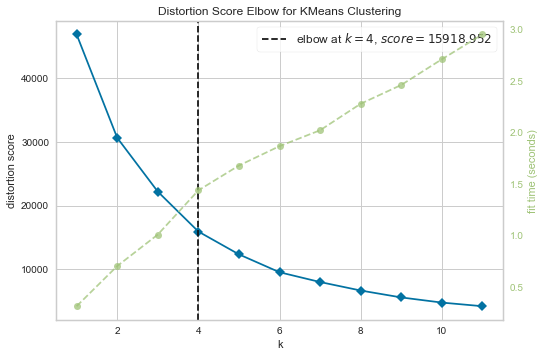

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(pca_features)   #Fit the data to the visualizer
visualizer.show()   

In [ ]:
# To perform the Silhouette we take as sample for a low computanally cost
data = pd.DataFrame(pca_features)   
sample_data = data.sample(n = 10000)

100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


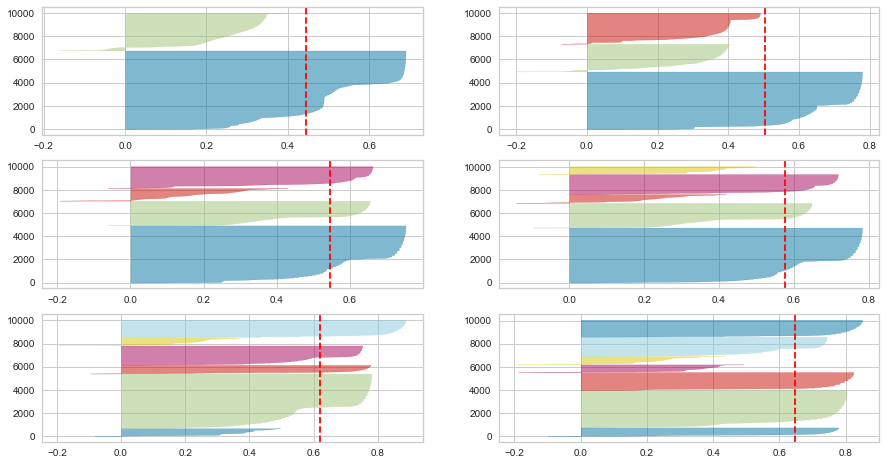

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in tqdm([2, 3, 4, 5 , 6 , 7] , colour= "#3285a8" ) :
    km = KMeans(n_clusters=i, n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(sample_data)


The Elbow Method shows that the optimanl number of cluster to use is : k = 4
The Silhouette approach shows as suboptimal k equal to 5 and  6, as the optimal one the k = 4 due the followinf reason :

* The absents of clusters with scores below-average silhouette scores 
* Low fluctuation in the size of the silhouette scores.

Such of that we can select the optimal number of cluster as a 4.

In [ ]:
# We add for each custumer the cluster he/she belogns
Custumer.insert(0, 'Cluster', cluster) 
Custumer.head(10)   

,Cluster,Num_of_Transaction,Balance>100_USD,Average_Amount,Average_Balance,Utilisation,gender,Most_Frequent_Location,Costumer_age,Max_transaction,...,Median_transaction,Number_of_woman,Number_of_man,Place_last,Place_first,Number_transaction>median,Date_last,Transaction_st_dev,Number_transaction>q3,Transaction_CV
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,0,2,2,2553.0,76340.635,73787.635,F,NOIDA,35.0,4750,...,2553.0,1,1,NOIDA,NEW DELHI,1,2016-09-26,3107.027197,1,0.860556
C1010012,0,1,1,1499.0,24204.490,22705.490,M,MUMBAI,28.0,1499,...,1499.0,0,1,MUMBAI,MUMBAI,1,2016-08-14,0.000000,1,0.000000
C1010014,0,2,2,727.5,100112.950,99385.450,F,MUMBAI,34.5,1205,...,727.5,1,1,MUMBAI,MUMBAI,1,2016-07-08,675.286976,1,0.656357
C1010018,2,1,1,30.0,496.180,466.180,F,CHAMPARAN,33.0,30,...,30.0,1,0,CHAMPARAN,CHAMPARAN,0,2016-09-15,0.000000,0,0.000000
C1010024,0,1,1,5000.0,87058.650,82058.650,M,KOLKATA,57.0,5000,...,5000.0,0,1,KOLKATA,KOLKATA,1,2016-08-18,0.000000,1,0.000000
C1010028,2,1,1,557.0,296828.370,296271.370,F,DELHI,34.0,557,...,557.0,1,0,DELHI,DELHI,1,2016-08-29,0.000000,0,0.000000
C1010031,0,2,2,932.0,5200.155,4268.155,M,VAPI,36.0,1460,...,932.0,0,2,TRICHY,VAPI,1,2016-04-08,746.704761,1,0.566524
C1010035,0,2,2,375.0,192648.755,192273.755,M,MUMBAI,36.5,700,...,375.0,0,2,NAVI MUMBAI,MUMBAI,1,2016-08-27,459.619408,0,0.866667
C1010036,3,1,1,208.0,355430.170,355222.170,M,GURGAON,27.0,208,...,208.0,0,1,GURGAON,GURGAON,0,2016-08-26,0.000000,0,0.000000


#### k means vs  k means++
k means and k means++ are both clustering algorithm.
k-means picks the initial centers at random and since that the final  clusters can be selected really badly in same unlucky case.

The K-means++ algorithm tries to solve this problem, by spreading the initial centers evenly by using probability distribution for the intial centroids.

In [ ]:
# Perform the k-means++
kmeans = KMeans(4 , init='k-means++')
kmeans.fit(pca_features)
centroids= kmeans.cluster_centers_

In the following plot we show the datapoints of the PCA and the final centroids after the two selected algorithm: 
* Datapoints in brown colour
* Final k means Centroids in green
* Final k means++ Centroids in red colours

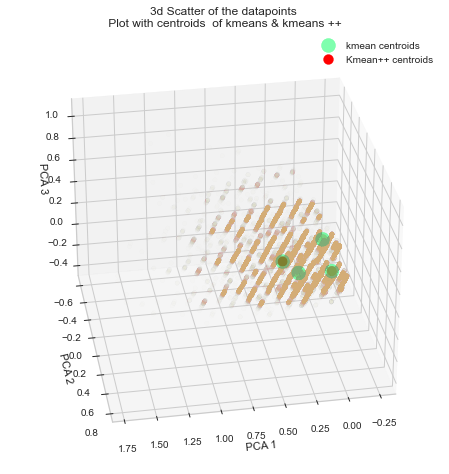

In [ ]:

ax = fig.add_subplot(projection='3d')
x = pca_features[: , :1]
y = pca_features[: , 1:2]
z = pca_features[: , 2:3]


fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection ="3d")

ax.scatter(centroids[: , :1] , centroids[: , 1:2], centroids [: , 2:3] , color = '#00ff5e' , s = 200 , alpha = 0.5 )
ax.scatter(centroids_Kmean[: , :1] , centroids_Kmean[: , 1:2], centroids_Kmean [: , 2:3] , color =  "#ff0000" , s = 100 )
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')



ax.scatter(x, y, z , alpha = 0.01 , color = '#d4ad77')
ax.legend(['kmean centroids', 'Kmean++ centroids'] )
plt.title("3d Scatter of the datapoints \n Plot with centroids  of kmeans & kmeans ++ " )
ax.view_init(30, 80)
plt.draw()

plt.show()

As we can see the kmean final centrids collides with the ones obtained with the kmeans++ algorithm.

The following plot show the datpoints colored matched with the cluster they belong.

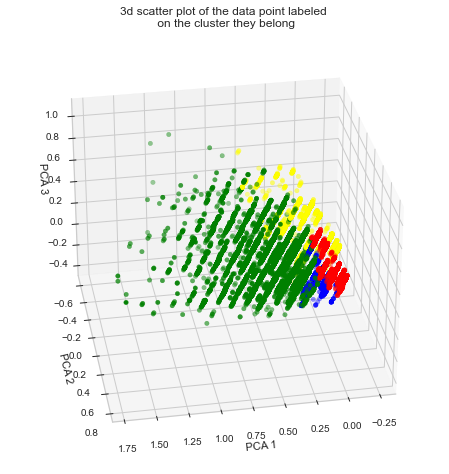

In [ ]:

ax = fig.add_subplot(projection='3d')
x = pca_features[: , :1]
y = pca_features[: , 1:2]
z = pca_features[: , 2:3]


fig = plt.figure(figsize = (14, 8))
ax = plt.axes(projection ="3d")

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

colors = ["green" , "blue", "yellow" , "red"] 
plt.title("3d scatter plot of the data point labeled \n on the cluster they belong")

ax.scatter(x, y, z  , c = Custumer['Cluster'] , cmap=matplotlib.colors.ListedColormap(colors))


ax.view_init(30, 80)

plt.draw()

plt.show()



## 2.4 Analysing your results!

2.4.1) Select the relevant variables

In [ ]:
# Releveant Variables we used for perform the pivot table
relevant = [ "gender", "Important_costumer" , "Average_Amount" , "Num_of_Transaction" ]

2.4.2) Categories the continuos variable into 4 catagories.

In [ ]:
data = Custumer[relevant]

q25 = data.Average_Amount.quantile(.33)   # Average amount greater than the 33% of the observation
q50 = data.Average_Amount.quantile(.66)   # Average amount greater than the 66% of the observation
q75 = data.Average_Amount.quantile(.75)   # Average amount greater than the 75% of the observation


# Devide the Average amount in classes
data.Average_Amount[data.Average_Amount < q25] = 1
data.Average_Amount[(data.Average_Amount > q25) & (data.Average_Amount < q50)] = 2
data.Average_Amount[(data.Average_Amount > q50) & (data.Average_Amount < q75 )] = 3
data.Average_Amount[data.Average_Amount > q75] = 4

# Devide the number of transaction in classes
data.Num_of_Transaction[data.Num_of_Transaction <= 2] = 1
data.Num_of_Transaction[(data.Num_of_Transaction > 2) &  (data.Num_of_Transaction <= 4) ] = 2
data.Num_of_Transaction[data.Num_of_Transaction == 5] = 3
data.Num_of_Transaction[data.Num_of_Transaction == 6] = 4


2.4.3) 
Perform the pivot table

First we define the cluster based on K-Means method , we select the number of cluster k equal to 4. And we compute the distance using the 2 pca in order to don't have computationally expensive operations.

In [ ]:
model = KMeans(n_clusters= 4)
pca = PCA(n_components=2)
pca_to_clusterize = pca.fit_transform(Custumer[columns])
df =  pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False) # Define an empty data frame
df["cluster"] = model.fit_predict(pca_to_clusterize)                            # Populate the dataframe according to the cluster

In [ ]:
df["Gender"] = data["gender"].values                                        # Add Gender values
df["Important_custumer"] = data["Important_costumer"].values                # Add Important custumer values
df["Number_of_Transaction"] = data["Num_of_Transaction"].values
df["Average_amount"] = data["Average_Amount"].values

Now we build a pivot data set we will populate with the pivot - table.

In [ ]:
# Define an empty datafrae
pivot =  pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)  

In [ ]:
# Percentage of male & female for each cluster
pivot["Female"] = df.groupby("cluster")["Gender"].apply( lambda x : (x =="F").sum() / ( ( x == "F").sum() +  ( x == "M").sum() ) * 100 )
pivot["Male"]   = df.groupby("cluster")["Gender"].apply( lambda x : (x =="M").sum() / ( ( x == "F").sum() +  ( x == "M").sum() ) * 100 )

In [ ]:
# Percentage of important custumer & not important custumer for each cluster
pivot["Important_custumer"]       = df.groupby("cluster")["Important_custumer"].apply( lambda x : (x == True).sum() / ( ( x == False).sum() +  ( x == True).sum() ) * 100 )
pivot["NOT_Important_custumer"]   = df.groupby("cluster")["Important_custumer"].apply( lambda x : (x == False).sum() / ( ( x == False).sum() +  ( x == True).sum() ) * 100 )

In [ ]:
# Percentage of poor , middle one band, middle two andricch custumer for each cluster
pivot["Poor"] = df.groupby("cluster")["Average_amount"].apply( lambda x : (x == 1).sum() / x.count() * 100 )
pivot["Middle_one"] = df.groupby("cluster")["Average_amount"].apply( lambda x : (x == 2).sum() / x.count() * 100 )
pivot["Middle_two"] = df.groupby("cluster")["Average_amount"].apply( lambda x : (x == 3).sum() / x.count() * 100 )
pivot["Rich"] = df.groupby("cluster")["Average_amount"].apply( lambda x : (x == 4).sum() / x.count() * 100 )

In [ ]:
# Percentage of Few , Some ,many and a lot of transaction  for each cluster

pivot["Few_transaction"] = df.groupby("cluster")["Number_of_Transaction"].apply( lambda x : (x == 1).sum() / x.count() * 100 )
pivot["Some_transaction"] = df.groupby("cluster")["Number_of_Transaction"].apply( lambda x : (x == 2).sum() / x.count() * 100 )
pivot["Many_transaction"] = df.groupby("cluster")["Number_of_Transaction"].apply( lambda x : (x == 3).sum() / x.count() * 100 )
pivot["A_lot_of_transaction"] = df.groupby("cluster")["Number_of_Transaction"].apply( lambda x : (x == 4).sum() / x.count() * 100 )

In [ ]:
pivot[["Male","Female"]]

,Male,Female
cluster,,
0,80.787217,19.212783
1,72.404482,27.595518
2,42.307692,57.692308
3,86.267606,13.732394


In [ ]:
pivot[["Important_custumer","NOT_Important_custumer"]]

,Important_custumer,NOT_Important_custumer
cluster,,
0,100.000000,0.000000
1,19.476416,80.523584
2,100.000000,0.000000
3,100.000000,0.000000


In [ ]:
pivot[["Poor","Middle_one","Middle_two","Rich"]]

,Poor,Middle_one,Middle_two,Rich
cluster,,,,
0,13.971161,20.362432,9.547935,56.079501
1,33.057355,33.034563,8.970790,24.792146
2,0.000000,0.000000,0.000000,100.000000
3,16.549296,12.323944,4.929577,66.197183


In [ ]:
pivot[["Few_transaction","Some_transaction","Many_transaction","A_lot_of_transaction"]]

,Few_transaction,Some_transaction,Many_transaction,A_lot_of_transaction
cluster,,,,
0,98.460639,1.519875,0.019486,0.00000
1,98.119810,1.866635,0.012835,0.00072
2,100.000000,0.000000,0.000000,0.00000
3,98.239437,1.760563,0.000000,0.00000


# Algorithmic Question



In [33]:
def guards_doors(n : int , m : int , g: int , students : list):
    doors = np.arange(0 , m )  # List of available doors
    free_guard = g             # Number of free guard ( set to g )
    first = set()              # Pre set of the students that enter first through the door
    last = set()               # Pre set of the students that enter last through the door
    dic = {}                   # Pre set of a dic
    for door in doors:         # Loop over the doors
        cond = True            # Set a condition in order to have only one student who enter firts in the door 
        for i in range(m):     # Loop over the students
            if students[i] == door and cond:  # The student associated with the door
                first.add(i)   # Add the first student 
                cond = False   # No student can enter first into that door anymore
            if students[i] == door:  # The student associated with the door
                dic[f"{door}"] = i   # Replacing when the student is associated with the door
    for k in dic.values():
        last.add(k)               # adding the last student for all the doors

    for i in range(m):            # Loop over the students
        if i in first:            # The door do need a guard 
            free_guard -= 1       # Reduce the number of guards free
        if free_guard == -1:      # There are no guard for the door :(
            return "NO" 
        if i in last:             # The door doesn not need a guard anymore
            free_guard += 1       # Increse the number of guards free
    return "YES"

In [34]:
guards_doors(n = 4 , m = 5 , g = 1 , students = [1, 1, 3, 3, 3])

'YES'

In [35]:
guards_doors( n = 2 , m = 5 , g = 1 , students =[ 1 , 2 , 1 , 2, 2 ])


'NO'